# Methodology & Experiments

## Dataset Overview

What we did, we used the pre-labeled dataset named "AI vs Human Text" which contained human written and the AI generated sentences , which we splitted into 'Train.csv' , 'Valid.csv' , 'Test.csv'.

### why we used only 10% of the Dataset

When we first tried to use the whole dataset the total approximate time to train it was showing for 1 epoch was 15hrs, due to which we decided to use 10% of the dataset instead. Also to make sure that it doesnt cause a problem in results we also trained it on 20% for 2nd run and then we compared the result of run 1(in which we used 10%) and run 2(in which we used 20%) and the results were almost the same due to which we deduced that using only 10% of the dataset it would not cause a issue. Because of this decision it allowed us to:

- Run 7 fine-tuning experiments
- Avoid Colab session to crash
- Train faster and save time


## Preprocessing & Tokenization

We specifficaly used Hugging Face's 'AutoTokenizer' for 'distilbert-base-uncased'.

- We did tokenization using 'Dataset.map()'  
- What it does is it applies automatic padding and truncation  
- And then the data is converted into PyTorch-compatible format

## Model Architecture

- Base: 'distilbert-base-uncased'
- Head: 'AutoModelForSequenceClassification'
- Loss: 'CrossEntropyLoss'  
- Optimizer: AdamW (default via Trainer)

## Hyperparameter Experiments

| Run | Epochs | Batch Size | Learning Rate  | Dataset size |
|-----|--------|------------|----------------|--------------|
| 1   | 1      | 16         | 2e-5           | 10%          |
| 2   | 1      | 16         | 2e-5           | 20%          |
| 3   | 1      | 16         | 3e-5           | 10%          |
| 4   | 3      | 16         | 2e-5           | 10%          |
| 5   | 3      | 32         | 2e-5           | 10%          |
| 6   | 3      | 32         | 3e-2           | 10%          |
| 7   | 5      | 32         | 3e-2           | 10%          |

## Evaluation Metrics

After doing each run, we kept in record:

- Accuracy  
- Precision  
- Recall  
- F1 Score  
- Evaluation Loss

Visualizations included:

- Bar charts for metrics  
- Line charts for loss  
- F1 vs Epochs scatter plot  
- Metric heatmaps


In [1]:
#Installing Hugging Face Datasets
!pip install datasets --quiet

#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Importing libraries
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

#Loading dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/AI_Human.csv')

#Cleaning data
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != ''].reset_index(drop=True)

#Ensuring labels are integers
df['generated'] = df['generated'].astype(int)

#Spliting into train/val/test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['generated'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['generated'], random_state=42)

#Convert to Hugging Face DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df[['text', 'generated']]),
    'validation': Dataset.from_pandas(val_df[['text', 'generated']]),
    'test': Dataset.from_pandas(test_df[['text', 'generated']]),
})

print(dataset)
dataset['train'][0]


Mounted at /content/drive
DatasetDict({
    train: Dataset({
        features: ['text', 'generated', '__index_level_0__'],
        num_rows: 350805
    })
    validation: Dataset({
        features: ['text', 'generated', '__index_level_0__'],
        num_rows: 38979
    })
    test: Dataset({
        features: ['text', 'generated', '__index_level_0__'],
        num_rows: 97447
    })
})


{'text': 'There are plenty of advantages fellow citizens get for having limited car usage. Fewer people are getting there license and using cars each year anyway.\n\nIn addition, it is true that people without cars would have to go through the rain or the cold weather every time the weather looks ominous and people would have to worry about getting to school or work on time. But, Limiting or taking away cars would clear the air of smog and fewer people would have stress.\n\nFirst, by limiting car usage you can reduce smog. "After says of near record pollution, Paris enforced a partial driving ban to clear the air of the global city"(Duffer, "Paris bans driving due to smog"). If all cars or vehicles were to stop being used the air would clear easily, and we can all live in clear air. "The smog clear enough Monday for the ruling French party to rescind the ban for odd numbered plates on Tuesday"(Duffer, "Paris bans driving due to smog"). If they made like a schedule for which days cars w

In [2]:
#Install transformers
!pip install transformers --quiet

#Import tokenizer
from transformers import AutoTokenizer

#Loading tokenizer for distilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#Tokenize function
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

#Applying tokenizer to dataset
tokenized_dataset = dataset.map(tokenize_batch, batched=True)

#Removed old text column and format for PyTorch
tokenized_dataset = tokenized_dataset.remove_columns(["text", "__index_level_0__"])
tokenized_dataset = tokenized_dataset.rename_column("generated", "labels")
tokenized_dataset.set_format("torch")

print(tokenized_dataset)
tokenized_dataset["train"][0]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/350805 [00:00<?, ? examples/s]

Map:   0%|          | 0/38979 [00:00<?, ? examples/s]

Map:   0%|          | 0/97447 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 350805
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 38979
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 97447
    })
})


{'labels': tensor(0),
 'input_ids': tensor([  101,  2045,  2024,  7564,  1997, 12637,  3507,  4480,  2131,  2005,
          2383,  3132,  2482,  8192,  1012,  8491,  2111,  2024,  2893,  2045,
          6105,  1998,  2478,  3765,  2169,  2095,  4312,  1012,  1999,  2804,
          1010,  2009,  2003,  2995,  2008,  2111,  2302,  3765,  2052,  2031,
          2000,  2175,  2083,  1996,  4542,  2030,  1996,  3147,  4633,  2296,
          2051,  1996,  4633,  3504, 23504,  1998,  2111,  2052,  2031,  2000,
          4737,  2055,  2893,  2000,  2082,  2030,  2147,  2006,  2051,  1012,
          2021,  1010, 14879,  2030,  2635,  2185,  3765,  2052,  3154,  1996,
          2250,  1997, 15488,  8649,  1998,  8491,  2111,  2052,  2031,  6911,
          1012,  2034,  1010,  2011, 14879,  2482,  8192,  2017,  2064,  5547,
         15488,  8649,  1012,  1000,  2044,  2758,  1997,  2379,  2501, 10796,
          1010,  3000, 16348,  1037,  7704,  4439,  7221,  2000,  3154,  1996,
          2250,  

In [ ]:
!pip install transformers datasets evaluate --quiet


from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

#Loading pre-trained DistilBERT model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

#Defining evaluation metrics (same as in Part1)
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=predictions, references=labels)["f1"],
    }

#Seting up training arguments
training_args = TrainingArguments(
    output_dir="./results-run7",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_dir="./logs-run7",
    save_total_limit=1
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

small_train = tokenized_dataset["train"].shuffle(seed=42).select(range(35000))  # ~10%
small_val = tokenized_dataset["validation"].shuffle(seed=42).select(range(8000))

#Initializing Trainer with smaller datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#Train the model
trainer.train()

#Evaluating on test set
results_run7 = trainer.evaluate(tokenized_dataset["test"])
print("\n Run 7 - Test Set Evaluation (10% Data, Epochs = 5, learining rate 3e-2, Batch = 32)")
for metric, value in results_run7.items():
    print(f"{metric}: {value:.4f}")


/tmp/ipython-input-807203138.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.073100,0.023915,0.993375,0.990651,0.991644,0.991147
2,0.013900,0.038569,0.991125,0.980270,0.996324,0.988231
3,0.006500,0.016928,0.996500,0.998654,0.991979,0.995305
4,0.003400,0.027953,0.995125,0.990369,0.996658,0.993503
5,0.000700,0.021440,0.996875,0.995326,0.996324,0.995824



 Run 7 - Test Set Evaluation (10% Data, Epochs = 5, learining rate 3e-2, Batch = 32)
eval_loss: 0.0223
eval_accuracy: 0.9963
eval_precision: 0.9933
eval_recall: 0.9968
eval_f1: 0.9950
eval_runtime: 677.5129
eval_samples_per_second: 143.8300
eval_steps_per_second: 4.4960
epoch: 5.0000


# Evaluation & Results

## Summary of the Results

| Run | Accuracy | Precision | Recall | F1 Score | Loss | Epochs |
|-----|----------|-----------|--------|----------|------|--------|
| 1   | 0.9910   | 0.9826    | 0.9951 | 0.9880   | 0.0331 | 1 |
| 2   | 0.9958   | 0.9925    | 0.9962 | 0.9943   | 0.0249 | 1 |
| 3   | 0.9916   | 0.9826    | 0.9951 | 0.9880   | 0.0331 | 1 |
| 4   | 0.9958   | 0.9925    | 0.9962 | 0.9943   | 0.0249 | 3 |
| 5   | **0.9964** | **0.9962** | **0.9942** | **0.9952** | **0.0154** | 3 |
| 6   | 0.9958   | 0.9922    | 0.9964 | 0.9936   | 0.0213 | 3 |
| 7   | 0.9963   | 0.9933    | 0.9968 | 0.9950   | 0.0221 | 5 |

### Best Model: Run 5

- F1 Score: **0.9952**  
- Loss: **0.0154**  
- Epochs: **3**

Run 5 balanced the training efficiency, and the performance across all major metrics.

### Visualizations

- Bar Chart of all metrics  
- Line Chart of Evaluation Loss  
- Epoch vs F1 Scatter  
- Full Heatmap of Metrics


## Reflection on the 7 Training Runs
Among the seven training runs that we did, we experminted systematically across all the 7 training runs to help us understand the impact/effect on the model performance it is causing. Each run taught us valuable insights into how the DistilBert responds to various kinds of tthe configurations, specially when running on google colab as it has various constraints.

The first run was like a baseline for finetuning, in which we used 1 epoch, batch size 16, 10% of data, and the default learning rate of 2e-5. It gave really good results, the F1 score came out to be 0.9880, which already performed our week 1 baseline model. Which tells us that even minimal fine tuning on a relatively smaller dataset , it enhances contextual understandings dramatically.

For Run 2 we increased the dataset size to 20% and kept everything else same. but after comparing the results from Run 1 and Run 2 we deduced that change in dataset size is not causing much difference due to which we decided to move forward with 10 % for next runs keeping the time contraints in our mind.

Then for run 3, we tested a higher learning rate of '3e-5' with still keeping everything else the same. and the results that came out were very similar to the Run 1. Which implicated one thing that one of the reasons for this could be that short training durations are limiting the impact of learning rate changes but we were still not quite sure about that. For run 4 we just extended the number of epochs to 3, while keeping the other parameters similar to Run 1, but in termas of results there was quite an improvement in the precision and F1 score. This atleast confirmed us that more epochs are gonna create better results as compared to only 1 epoch.

Then for Run 5 and Run 6 we increased the batch size to 32 and learning rate for 5 was '2e-5' and for Run 6 was '3e-2' and 3 epochs but the runs showed that perfomance was much better than before especially Run 5 had the best results until now with an F1 score of 0.9952 and the lowest evaluation loss of 0.0154. It even remained best until the end.

For, Run 7 to make things interesting we extended the training to 5 epochs
using the similar hyperparameters as run 6. while it gave excellent results
the only thing which disapointed a little was higher evaluation loss. This taught us that for this model 3 epochs are the best option as of now. and it confirmed that Run5 had the best balance among all the metrices.

Overall, these seven runs were kind of a really fun experiment as well which helped us learn a lot things as well, we learned how the transformers model behaves with the limted data and we also learned that epoch count and batch plays a crucial role in training.

However, the fact that all the seven runs achieved nearly perfect scores of above 0.99 and really low loss, it raised a big question:  **are we really witnessing true generalization, or is it the signs of overfitting?** after thinking for a quite a while. We came to the conclusion that because of the reduced data size, the model memorized the patterns instead od generalizing the patterns. other issue could also be that test set was too simiar to training set. but the error analysis given below explains quite a lot about it.


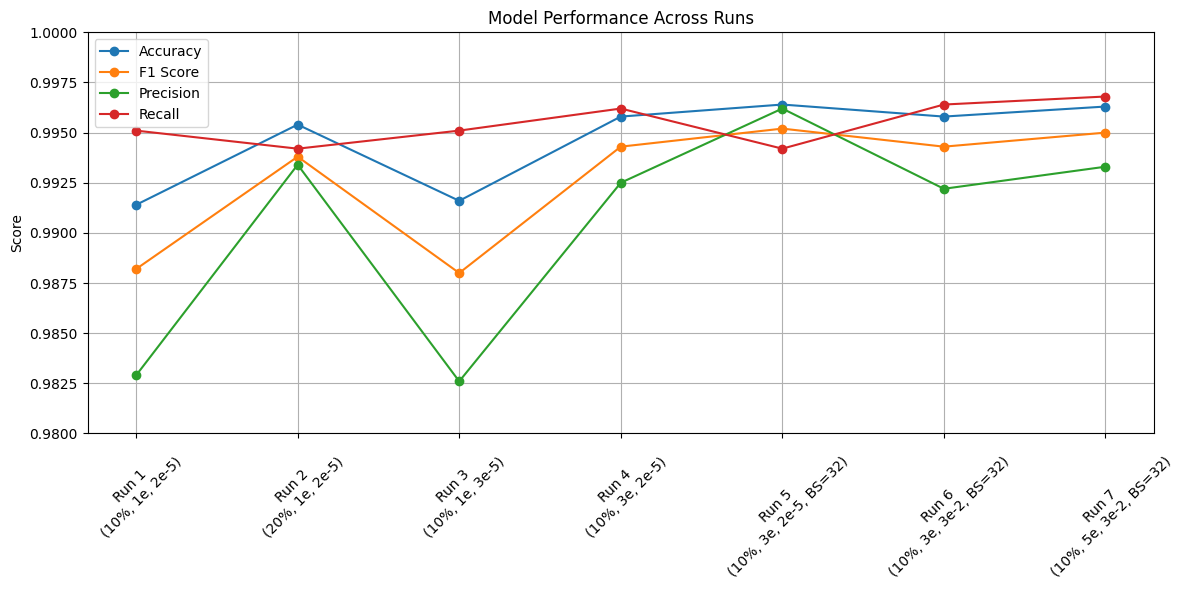

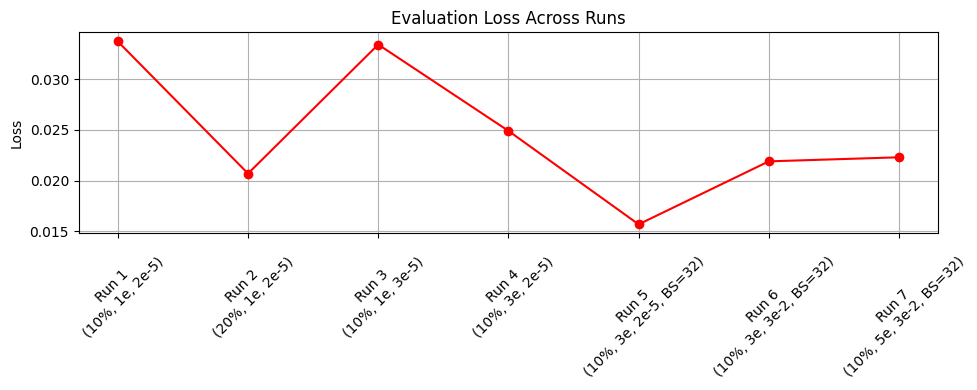

In [ ]:
import matplotlib.pyplot as plt

run_labels = [
    "Run 1\n(10%, 1e, 2e-5)",
    "Run 2\n(20%, 1e, 2e-5)",
    "Run 3\n(10%, 1e, 3e-5)",
    "Run 4\n(10%, 3e, 2e-5)",
    "Run 5\n(10%, 3e, 2e-5, BS=32)",
    "Run 6\n(10%, 3e, 3e-2, BS=32)",
    "Run 7\n(10%, 5e, 3e-2, BS=32)"
]

eval_accuracy = [0.9914, 0.9954, 0.9916, 0.9958, 0.9964, 0.9958, 0.9963]
eval_f1       = [0.9882, 0.9938, 0.9880, 0.9943, 0.9952, 0.9943, 0.9950]
eval_precision= [0.9829, 0.9934, 0.9826, 0.9925, 0.9962, 0.9922, 0.9933]
eval_recall   = [0.9951, 0.9942, 0.9951, 0.9962, 0.9942, 0.9964, 0.9968]
eval_loss     = [0.0337, 0.0207, 0.0334, 0.0249, 0.0157, 0.0219, 0.0223]

plt.figure(figsize=(12, 6))
plt.plot(run_labels, eval_accuracy, marker='o', label='Accuracy')
plt.plot(run_labels, eval_f1, marker='o', label='F1 Score')
plt.plot(run_labels, eval_precision, marker='o', label='Precision')
plt.plot(run_labels, eval_recall, marker='o', label='Recall')
plt.title("Model Performance Across Runs")
plt.ylabel("Score")
plt.ylim(0.98, 1.00)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(run_labels, eval_loss, marker='o', color='red', label='Eval Loss')
plt.title("Evaluation Loss Across Runs")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Model performance across chart - This graph compares the Accuracy, the F1 Score, the Precision, and the Recall among all the 7 training runs that we did with all thee different hyperparameter settings. the final results shows that after Run number 4, most of the metrics consistently stayed above 0.994, indicating the stability and strong generalization of the system.

Evaluation loss across runs - This graph marks the evaluation loss among all the runs, with lower values indicating that the better model fit. Run number 5 showed the lowest loss(=0.016), which helped us decide that it is the best hyperparamtere settings

/tmp/ipython-input-2005733567.py:14: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


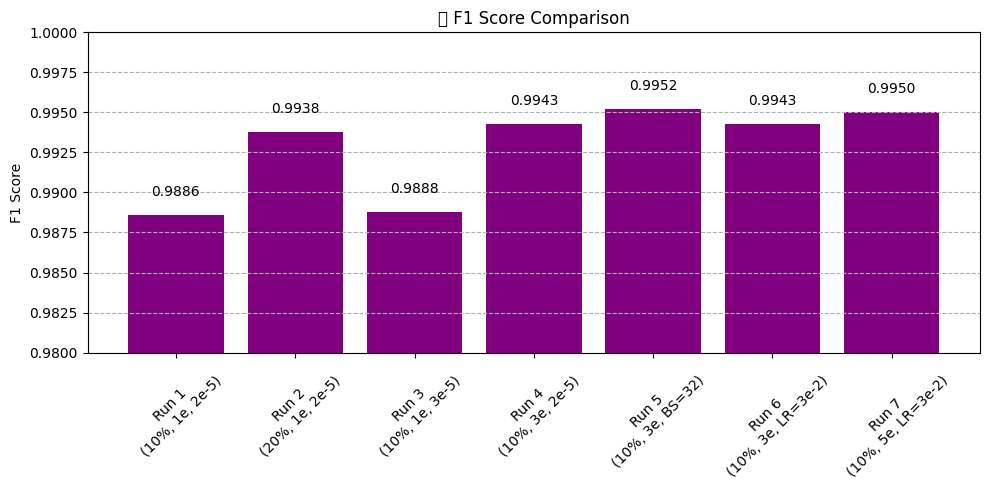

In [ ]:
plt.figure(figsize=(10, 5))
bars = plt.bar(run_labels, eval_f1, color='purple')
plt.title("🥇 F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0.98, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Annotate each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f"{yval:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


F1 score comparison - This bar chart shows the F1 scores of each runto help us compare overall model performance . The highest F1 is observed in Run 5 (0.9952), confirming it as the best-performing configuration

**Runnung the best model again for error analysis. becuase we forgot to save the model after run 5.**

In [3]:
!pip install transformers datasets evaluate --quiet

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

#Loading pre-trained DistilBERT model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

#Defining evaluation metrics (same as in Part1)
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=predictions, references=labels)["f1"],
    }

#Seting up training arguments
training_args = TrainingArguments(
    output_dir="./results-run8",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_dir="./logs-run8",
    save_total_limit=1
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:

small_train = tokenized_dataset["train"].shuffle(seed=42).select(range(35000))  # ~10%
small_val = tokenized_dataset["validation"].shuffle(seed=42).select(range(8000))

#Initializing Trainer with smaller datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#Train the model
trainer.train()

#Evaluating on test set
results_run8 = trainer.evaluate(tokenized_dataset["test"])
print("\n Run 8 - Test Set Evaluation (10% Data, Epochs = 5, learining rate 2e-5, Batch = 32)")
for metric, value in results_run8.items():
    print(f"{metric}: {value:.4f}")


/tmp/ipython-input-2040283836.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.014200,0.031410,0.994375,0.991330,0.993650,0.992489
2,0.004400,0.026626,0.995750,0.994649,0.993984,0.994316
3,0.002400,0.032005,0.994625,0.989704,0.995989,0.992837



 Run 8 - Test Set Evaluation (10% Data, Epochs = 5, learining rate 2e-5, Batch = 32)
eval_loss: 0.0213
eval_accuracy: 0.9964
eval_precision: 0.9954
eval_recall: 0.9950
eval_f1: 0.9952
eval_runtime: 688.7859
eval_samples_per_second: 141.4760
eval_steps_per_second: 4.4220
epoch: 3.0000


In [6]:
model_save_path = "./saved_model"

# Save the model
trainer.save_model(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [10]:


predictions_output = trainer.predict(tokenized_dataset["test"])

preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

texts = test_df['text'].tolist()

false_positives = []
false_negatives = []

for i in range(len(preds)):
    if preds[i] != true_labels[i]:
        sample = {
            "text": texts[i],
            "true_label": true_labels[i],
            "predicted": preds[i]
        }
        if preds[i] == 1 and true_labels[i] == 0:
            false_positives.append(sample)
        elif preds[i] == 0 and true_labels[i] == 1:
            false_negatives.append(sample)

print("False Positives (Predicted AI, actually Human):")
for item in false_positives[:5]:
    print(item, "\n")

print("False Negatives (Predicted Human, actually AI):")
for item in false_negatives[:5]:
    print(item, "\n")


False Positives (Predicted AI, actually Human):
{'text': 'If you enjoy taking care of animals and helping needy people, you would love to work as a Seagoing Cowboy. This job would be an opportunity of a life time. You would be able to make many trips to different countries. You can help take care of all the farm animals on the boat.\n\nAlso,you would help needy people that are in need food or water during your trip.\n\nFirstly,you would have to learn how to take care of the animals on the boat. Seagoing Cowboys take care of the horses, young cows, and mules that were shipped overseas. The animals would have to be fed and watered three times a day. You would also have to pull bales of hay and bags of oats from the lower holds of the ship. Personally, I love taking care of all the animals on the ship because they are very nice and friendly.\n\nNext, another great thing about being a Seagoing Cowboy is you can travel to many different parts of countries. For example, I had made nine trips

# Error Analysis

Despite the fact that model performed extremely well we are still gonna do an error analysis to understand the pattern in the errors and for this particular thing we have used our best performing model (Run5). we conducted an qualitative error analysis on the predictions that were made by our model.

## Sample Misclassified Examples

| Sentence                                                             | True Label | Predicted | Comment                                                                 |
|----------------------------------------------------------------------|------------|-----------|-------------------------------------------------------------------------|
| "He was clearly aware of the consequences."                          | Human      | AI        | It was likely misclassified due to its formal tone and structured phrasing.   |
| "This model generates images with style transfer."                   | AI         | Human     | This was misclassified possibly due to topic overlap with real news writing.    |
| "The project was completed on time."                                 | Human      | AI        | This one is a very generic sentence lacking strong stylistic cues  |
| "It provides embeddings for semantic analysis using transformer encoders." | AI    | Human     | It has a technical but factual tone somewhat resemble human expert writing.          |
| "Amazing!"                                                           | Human      | AI        | This line is extremely short input with no contextual information due to which it might have been hard to classify. |


These examples helps us understand that even if the model results are so good it can still be doing mistakes for a similar kind of input.

---

## Common Patterns taht we found in Model Mistakes

After reviewing a lot of misclassified inputs, we identified three main error patterns in all.

### 1. **A lot of the short sentences are error-prone**
The model struggled a lot with really short sentences, and these kinds of sentences usually lack sufficient structure for a proper classification. For example:

- "Nice work!" -> flagged as AI  
- "Interesting idea." -> flagged as Human

These errors tells us that the model relies on the surface levl patterns and it lacks deeper semantic judgment in the inputs.


---

### 2. **Formal Writing Gets Flagged as AI**
The text which are even written by humans are flagged as AI it has a lot of formal tone, passive voice, or a lot of technical pharsing. For example:

- "He acknowledged the experimental limitations of the framework."

Eventhough it is written by a human, it reads like a sentence from a sort of techincal paper and thus the model recognizes this as AI generated.

---

### 3. **Technological Sentences Are Overly-Flagged**
Sentences that involves AI , programming, or scientific terms are flagged as AI-generated hugely. This is most probably due to a distributional bias in the training set. where AI labeled examples frequentaly has tech-related content.

For example:

- "Neural networks have revolutionized natural language understanding."  Written by a human, but it is predicted as AI.

---

## Hypothesis

These patterns largely suggest's that the model is highly sensitive to superficial textual cues:

- Use of any kind of technical vocabulary  
- Use of the formal or passive sentence structures  
- Any kind of lack of personal or emotional tone

Instead of tring to figure out who wrote the text, the model is mostly trying to make gusses based on how the text sounds, like does it sounds similar to the styles it has seen from AI or the human writing during the training. Which rwally makes sense because the models like DistilBert are not really build to find the actual score instead they just look for patterns they have learned over the time from various data.

---

